# Modelling

In [16]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from scipy.ndimage.filters import gaussian_filter
import shap
import pickle
from math import cos, sin, asin, sqrt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import plot_importance

import tensorflow as tf    
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Input, concatenate, SimpleRNN, Dropout, Bidirectional, Embedding, GRU
from keras.callbacks import History
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
history = History()

In [17]:
df = pd.read_csv("C:\\Data\\Processed_M3\\Sites_10min_time_final.csv")

In [18]:
timeInterval = '10min_time'
# df.columns = ['date', 'site', timeInterval, 'occupancy0', 'speed0', 'volume0','dateTime', 'hour', 'dayOfWeek', 'dayType']
df.columns = ['date','site','timeInterval','occupancy0','speed0','volume0','dateTime','hour','dayOfWeek','dayType','density0','state0']
sites = set(df['site'])
dateTime = pd.to_datetime(df['dateTime'])
df['interval'] = [v.hour*6+int(v.minute/10) for v in dateTime]
df

,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval
0,2016-07-01,14005 WB P0,00:00:00,0.000000,100.000000,67.728571,2016-07-01 00:00:00,0,4,0,0.000000,0.0,0
1,2016-07-01,14005 WB P0,00:10:00,0.000000,100.000000,62.821429,2016-07-01 00:10:00,0,4,0,0.000000,0.0,1
2,2016-07-01,14005 WB P0,00:20:00,0.000000,100.000000,53.171429,2016-07-01 00:20:00,0,4,0,0.000000,0.0,2
3,2016-07-01,14005 WB P0,00:30:00,0.000000,100.000000,51.971429,2016-07-01 00:30:00,0,4,0,0.000000,0.0,3
4,2016-07-01,14005 WB P0,00:40:00,0.000000,100.000000,44.350000,2016-07-01 00:40:00,0,4,0,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51403,2016-08-21,14063 WB P0,23:10:00,0.890000,97.012222,62.000000,2016-08-21 23:10:00,23,6,1,1.260833,0.0,139
51404,2016-08-21,14063 WB P0,23:20:00,0.436667,96.243056,78.750000,2016-08-21 23:20:00,23,6,1,0.618611,0.0,140
51405,2016-08-21,14063 WB P0,23:30:00,0.490000,96.452778,36.000000,2016-08-21 23:30:00,23,6,1,0.694167,0.0,141
51406,2016-08-21,14063 WB P0,23:40:00,0.520000,96.370833,70.687500,2016-08-21 23:40:00,23,6,1,0.736667,0.0,142


## Features

In [19]:
# The lag is the time distance between time-factors and time-target
# If the lag is 0, we say we try to use the data 10 mins ago to forecast the now traffic condition
# If the lag is 2, we say we try to use the data 30 mins ago to forecast the now traffic condition
# If the lag is 5, we say we try to use the data 60 mins ago to forecast the now traffic condition

window = 6*10
lag = 1 # lag 0 means the label is 10 mins later
lag = lag + window

# sites = ['14005 WB P0', '14017 WB P0', '14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0', '14061 WB P0']
# # sites = ['14025 WB P0']
# sites = ['14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0']

# lag_names = ['volume'+str(t) for t in range(lag+1)]
volume_names = 'volume'+str(lag)
hour_names = 'hour'+str(lag)
dayOfWeek_names = 'dayOfWeek'+str(lag)
interval_names = 'interval'+str(lag)
dayType_names = 'dayType'+str(lag)
data_features = [volume_names, hour_names, dayOfWeek_names, interval_names, dayType_names]

column_names = list(df.columns.values) + data_features
print(column_names)

data = pd.DataFrame()
for site in sites:
    df1 = df[df['site']==site]
    df1.sort_values('dateTime')
    # df1 = pd.concat([df1]+ [df1['volume0'].shift(t) for t in range(lag+1)], axis=1)
    df1 = pd.concat([df1]+ [df1['volume0'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['hour'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayOfWeek'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['interval'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayType'].shift(lag)], axis=1)
    data = data.append(df1)
data.columns = column_names
#data = data.dropna()

features = ['volume' + str(lag)]
features_name = 'volume' + str(lag)
aux_features = []#[interval_names, dayType_names]
columns = features + aux_features
data

['date', 'site', 'timeInterval', 'occupancy0', 'speed0', 'volume0', 'dateTime', 'hour', 'dayOfWeek', 'dayType', 'density0', 'state0', 'interval', 'volume60', 'hour60', 'dayOfWeek60', 'interval60', 'dayType60']


,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval,volume60,hour60,dayOfWeek60,interval60,dayType60
288,2016-07-01,14025 WB P0,00:00:00,0.738750,98.992381,132.000000,2016-07-01 00:00:00,0,4,0,1.046562,0.0,0,NaN,NaN,NaN,NaN,NaN
289,2016-07-01,14025 WB P0,00:10:00,0.868750,93.917778,134.000000,2016-07-01 00:10:00,0,4,0,1.230729,0.0,1,NaN,NaN,NaN,NaN,NaN
290,2016-07-01,14025 WB P0,00:20:00,0.888750,88.338294,124.000000,2016-07-01 00:20:00,0,4,0,1.259062,0.0,2,NaN,NaN,NaN,NaN,NaN
291,2016-07-01,14025 WB P0,00:30:00,0.836250,95.020278,84.742857,2016-07-01 00:30:00,0,4,0,1.184687,0.0,3,NaN,NaN,NaN,NaN,NaN
292,2016-07-01,14025 WB P0,00:40:00,0.567500,98.009444,96.000000,2016-07-01 00:40:00,0,4,0,0.803958,0.0,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50971,2016-08-21,14037 WB P0,23:10:00,2.046667,95.467143,250.000000,2016-08-21 23:10:00,23,6,1,2.899444,0.0,139,1368.0,13.0,6.0,79.0,1.0
50972,2016-08-21,14037 WB P0,23:20:00,1.558333,96.452659,208.000000,2016-08-21 23:20:00,23,6,1,2.207639,0.0,140,1426.0,13.0,6.0,80.0,1.0
50973,2016-08-21,14037 WB P0,23:30:00,1.540000,93.907897,186.000000,2016-08-21 23:30:00,23,6,1,2.181667,0.0,141,1422.0,13.0,6.0,81.0,1.0
50974,2016-08-21,14037 WB P0,23:40:00,1.125000,96.538452,308.375000,2016-08-21 23:40:00,23,6,1,1.593750,0.0,142,1320.0,13.0,6.0,82.0,1.0


## Evaluation

In [20]:
def evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Function for calculating accuracy metrics. Inputs are list of predictions.
    """
    results = {}
    
    results['MAE train'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['MAE test'] = mean_absolute_error(y_pred_test, y_test_true)
    results['MAE train base'] = mean_absolute_error(y_base_train, y_train_true)
    results['MAE test base'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['MRE test'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['RMSE test'] = math.sqrt(mean_squared_error(y_pred_test, y_test_true))
    
    #print('results', results)
    #print('y_base_train', y_base_train) # y_base_train, y_base_test are not dataframe anymore
    
    total_error_train, total_error_test = 0,0
    total_error_train_base, total_error_test_base = 0,0
    
    for i in range(0, len(y_train_true)):
        total_error_train_base += np.abs(y_base_train[i] - y_train_true[i])
        total_error_train += np.abs(y_pred_train[i] - y_train_true[i])
    
    for i in range(0, len(y_test_true)):
        total_error_test_base += np.abs(y_base_test[i] - y_test_true[i])
        total_error_test += np.abs(y_pred_test[i] - y_test_true[i])
        
    results['Baseline model total error (on train set)'] = total_error_train_base
    results['Baseline model total error (on test set)'] = total_error_test_base
    results['Our model total error (on train set)'] = total_error_train
    results['Our model total error (on test set)'] = total_error_test 
    
    return results

In [21]:
def evaluate_model_ann(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Calculate mean squared error and total absolute error.
    evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)
    """
    results = {}
    
    results['train mae'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['test mae'] = mean_absolute_error(y_pred_test, y_test_true)
    results['base train mae'] = mean_absolute_error(y_base_train, y_train_true)
    results['base test mae'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['test mre'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['test rmse'] = mean_squared_error(y_pred_test, y_test_true)**.5
    
    error_train, error_test = [],[]
    error_train_base, error_test_base = [],[]
    
    for i in range(0, len(y_train_true)):
        error_train_base.append(np.abs(y_base_train[i] - y_train_true[i]))
        error_train.append(np.abs(y_pred_train[i] - y_train_true[i]))
    
    for i in range(0, len(y_test_true)):
        error_test_base.append(np.abs(y_base_test[i] - y_test_true[i]))
        error_test.append(np.abs(y_pred_test[i] - y_test_true[i]))
        
    results['base model train error'] = sum(error_train_base)
    results['base model test error'] = sum(error_test_base)
    results['our model train error'] = sum(error_train)
    results['our model test error'] = sum(error_test) 
    
    return results

In [22]:
def scatter_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)
    y_predicted = y_pred_test
    t = y_true
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_predicted, c=t, s=2, cmap='viridis')
    ax.plot([0,2000], [0,2000], 'k--', lw=4)
    ax.set_xlabel('True', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)
    ax.xaxis.set_ticks(np.arange(0,2001,500))
    ax.yaxis.set_ticks(np.arange(0,2001,500))
    ax.tick_params(axis='both', labelsize=15, direction='inout',bottom=True, left=True)
    #regression line
    y_true, y_predicted = y_true.reshape(-1,1), y_predicted.reshape(-1,1)
    ax.annotate("R2 = {:.3f}".format(r2_score(y_true, y_predicted)), (0, 1400), fontsize=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def time_series_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)*6
    y_predicted = y_pred_test*6
    t = y_true
    fig, ax = plt.subplots(figsize=(10, 1.5))
    plt.plot(y_predicted, 'r', lw=.5)
    plt.plot(y_true, 'b', lw=.5)
    ax.set_ylabel('Flow', fontsize=12)

    ax.tick_params(axis='both', labelsize=12, direction='inout',bottom=True, left=True)
    ax.set_xticklabels([])
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def show_time_scatter_plot(y_test,y_pred_test,title = "BiLSTM\\"):
    
    filePath = os.getcwd() + '\\Figs\\Scatter\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):                                     
        os.makedirs(filePath)
    scatter_plot(y_test,y_pred_test,imagePath)
    
    filePath = os.getcwd() + '\\Figs\\TimeSeries\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):
        os.makedirs(filePath)
    time_series_plot(y_test,y_pred_test,imagePath)

In [23]:
def feature_importance(x_train):
    crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    plt.figure(figsize = (6, 8))
    dt_importance_df = pd.DataFrame({"attributes": x_train.columns, "importance": dt.feature_importances_})
    dt_importance_df = dt_importance_df.sort_values("importance", ascending = True)
    dt_importance_df = dt_importance_df[dt_importance_df["importance"] > 0.001]
    plt.barh(dt_importance_df["attributes"], dt_importance_df["importance"], orientation = "horizontal", color = crayon)
    plt.xlabel("Feature Importance")

## Helper Functions for Normalising Data

In [24]:
def denormalise(predictions, scaler): #IMPORTANT: run this
    """
    Denormalise the predictions back to the previous scale. 
    """
    predictions = predictions.reshape(1,-1)
    pred = scaler.inverse_transform(predictions)
    
    return pred

In [25]:
def normalise(columns, df): #IMPORTANT: run this
    """
    Normalise variables given the list 'columns'. Used for SVR model. 
    
    Parameters:
    columns (list): list of strings containing feature names that need to be normalised.
    df (pandas dataframe): training data.
    
    """
    min_max_scaler = preprocessing.MinMaxScaler() #normalise to make variables comparable 
    final_df = pd.DataFrame(min_max_scaler.fit_transform(df[columns]), columns = columns)
    
    for col in df.columns: #add back the columns that weren't normalised
        if col not in columns: 
            final_df[col] = df[col].values
    
#     if 'volume' in columns: #also store the unnormalised travel times if necessary 
#         final_df['volume_unnorm'] = df['volume'].values
    return final_df, min_max_scaler

In [26]:
def create_auxiliary_input(train_x, test_x, features): 
    """
    Function to filter out only the auxiliary features. 
    Auxiliary features are all the other features other than the lagged features.
    
    """
    
    train_x_aux = train_x[features]
    test_x_aux = test_x[features]
    
    return train_x_aux, test_x_aux

## Helper Functions for Window the data

when we try to use 1 previous hour to preduct 1 further hour, the input window is 2.

Input window = history length (1) + lag (1)

In [27]:
def time_series_window_generator(x,y,lag,window,features_name):
    """
    1. we assume the train test is dataframe format, 
    and it contains both time series and other features
       
    2. we consider the base line is the first data points of input (only work for methods don't need normalization)
    
    3. for methods use normalization, we need to generate the baseline inside the method itself
    """
    # to create the correct window match
    # --------------------------------------
    #  1  2  3  4  5   6  ......
    # --------------  --
    #   features      label
    # 
    # this is a window 6, lag 1, data length 5 data match for time series.
    # didn't use this function for now because vol-x are manually generated

    local_x = x.copy()
    local_x_base = x[features_name].copy()
    local_y = y.copy()
    #print(y)
    
    index_x = local_x.index
    index_y = local_y.index
    data_n = len(x) - lag               # for 5 window 0 lag, means 5 data points predict 1 future hour.

    y_base_windowed = []
    y_windowed = []
    x_windowed = []
    
    for i in range(data_n):
        x_windowed.append(local_x[i : i+window].values.tolist())  # get features
        y_windowed.append(local_y[index_y[i]])
        y_base_windowed.append(local_x_base[index_x[i]])
#         if i == 0:
#             print('start_index ',index_x[0])
#             print("* processing the time series " + str(window) +" window in lag " + str(lag-window))
#             print('features: ', local_x[i : i+window], ' in ', str(index_x[0]),  ' to ', str(index_x[0]+window))
#             print('label: ', local_y[index_y[i]], ' in ', str(index_y[0]))

    # reshape to (n_sample, n_feautre * n_length) still 2d
    x_windowed = np.array(x_windowed)
    # print('input shape before:', x_windowed.shape)
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0],-1))
    # print('input shape after:', x_windowed.shape)
    
    return x_windowed, y_windowed, y_base_windowed

In [28]:
def prepare_nn_data(x,y,lag,window,time_feautre_name = 'volume1'):
    """
    Reformat data to appropriate form for the recurrent neural
    network.
    1. get time series data in array (n_sample,1,n_length)
    2. get aux data in array (n_sample,1,n_features)
    3. get y & y_base in array (n_sample,)
    
    to separate 1 and 2, use time_feautre_name
    """
    # separate 1 and 2
    print("==================")
    print("process ann data")
    local_x = x.copy()
    index_y = y.index
    time_feature_df = local_x[time_feautre_name]
    aux_feature_df = local_x.drop(time_feautre_name, axis=1)

    x_windowed = []
    x_windowed_aux = []
    y_base_windowed = []
    y_windowed = []
    
    data_n = len(x) - lag
    for i in range(data_n):
        x_windowed.append(time_feature_df[i : i+window].values.tolist())     # get time series features
        x_windowed_aux.append(aux_feature_df[i : i+window].values.tolist())  # get other time related features
        y_base_windowed.append(time_feature_df[i])                    # get first of input time slot data as baseline 
        y_windowed.append((y[index_y[i]]))                                   # get grand truth
        
    # reshape to (n_sample, 1 feautre)
    x_windowed = np.asarray(x_windowed).astype(np.float32)
    x_windowed_aux = np.asarray(x_windowed_aux).astype(np.float32)
    y_base_windowed = np.asarray(y_base_windowed).astype(np.float32)
    y_windowed = np.asarray(y_windowed).astype(np.float32)
    #print('before reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('sample input time series:',x_windowed[0])
    #print('sample input aux features::',x_windowed_aux[0])
    #print('target shape:',y_windowed.shape)
    #print('sample target:',y_windowed[0])
    
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0], 1, x_windowed.shape[1]))
    x_windowed_aux = np.reshape(x_windowed_aux, (x_windowed_aux.shape[0],1, -1))      # for merge must be n,1,m.
    y_base_windowed = np.reshape(y_base_windowed, (y_base_windowed.shape[0], 1))
    y_windowed = np.reshape(y_windowed, (y_windowed.shape[0], 1))
    #print('after reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('target shape:',y_windowed.shape)
    
    return x_windowed, x_windowed_aux, y_windowed, y_base_windowed

# Models

# Neural network models

The following sections use different neural networks, which are MLP, RNN, LSTM, GRU and BILSTM. However their general structure are same.

See below


In [29]:
# ################
# this model architecture actually is a 2 branch model
#  input1 time series               
#     |
#  RNN model        
#     |                       
#  RNN output     input2 other features
#     |                     |
#     -----------------------
#                |
#              Concat
#                |
#               MLP
#                |
#           final output


# RNN

14025 WB P0
process ann data
process ann data
train mae 54.2679
test mae 56.76352
base train mae 960.2717
base test mae 957.29205
test mre 0.1154919
test rmse 82.27938957733431
base model train error [5481230.]
base model test error [1394774.6]
our model train error [309761.84]
our model test error [82704.54]
Model R square (train):  0.9846940893944145
Model R square (test):  0.9815400744072891
Base R square (train):  -1.8554813539865083
Base R square (test):  -1.9010113697500208


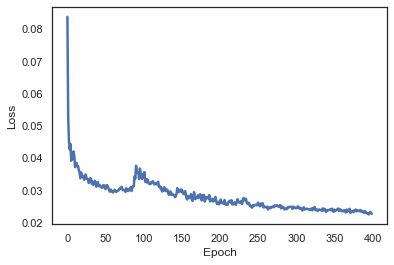

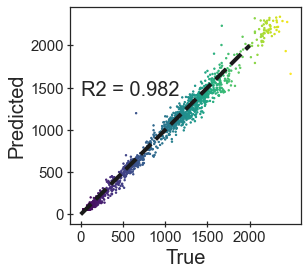

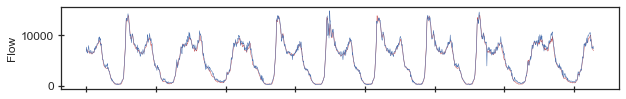

14005 WB P0
process ann data
process ann data
train mae 30.350039
test mae 34.00753
base train mae 444.871
base test mae 464.02466
test mre 0.11452543
test rmse 48.10382549593899
base model train error [2539324.]
base model test error [676083.9]
our model train error [173238.3]
our model test error [49548.973]
Model R square (train):  0.9771273331798153
Model R square (test):  0.9727360590970718
Base R square (train):  -1.939917243276974
Base R square (test):  -2.029742498002954


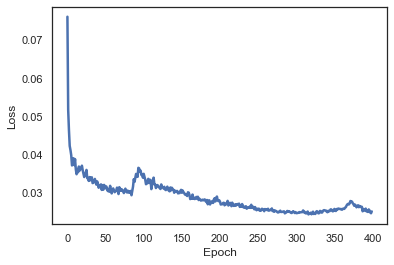

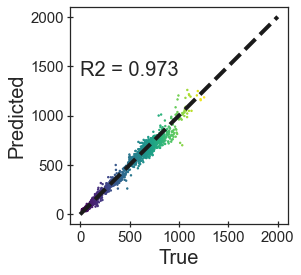

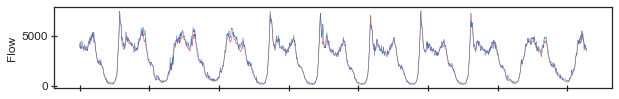

14011 WB P0
process ann data
process ann data
train mae 61.56395
test mae 66.61982
base train mae 802.57025
base test mae 801.7417
test mre 0.17108734
test rmse 89.30207908064067
base model train error [4581071.]
base model test error [1168137.5]
our model train error [351406.88]
our model test error [97065.15]
Model R square (train):  0.9742337348569768
Model R square (test):  0.9695742376033607
Base R square (train):  -1.848967053685731
Base R square (test):  -1.8901742507247379


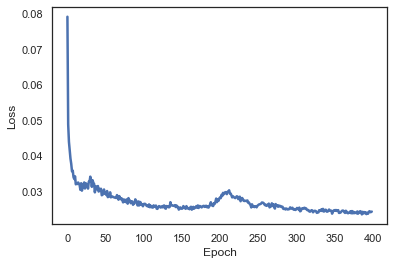

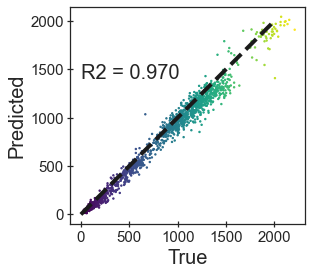

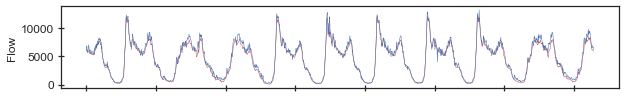

14063 WB P0
process ann data
process ann data
train mae 22.516346
test mae 23.986803
base train mae 339.58508
base test mae 333.9512
test mre 0.14854644
test rmse 35.297528629406195
base model train error [1938353.]
base model test error [486567.]
our model train error [128523.086]
our model test error [34948.76]
Model R square (train):  0.976517679761604
Model R square (test):  0.9721972334452391
Base R square (train):  -1.8535261134745817
Base R square (test):  -1.9134284655610925


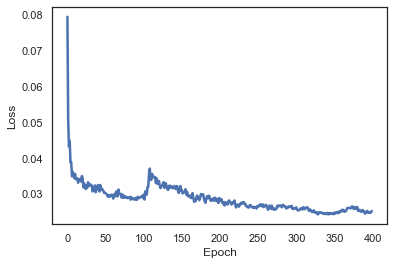

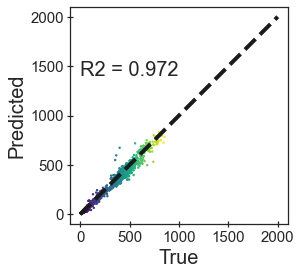

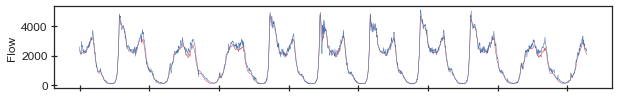

14055 WB P0
process ann data
process ann data
train mae 76.957886
test mae 81.61197
base train mae 1115.3179
base test mae 1107.8965
test mre 0.1621899
test rmse 115.03434864068862
base model train error [6366235.5]
base model test error [1614205.2]
our model train error [439275.47]
our model test error [118908.72]
Model R square (train):  0.977389190455555
Model R square (test):  0.9723144965855307
Base R square (train):  -1.9585145458578728
Base R square (test):  -2.0118294712927582


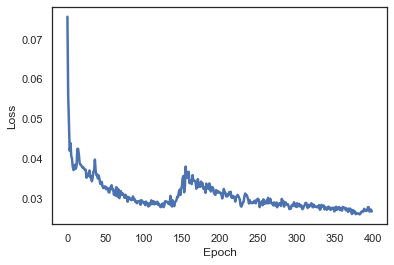

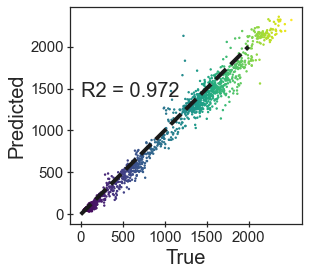

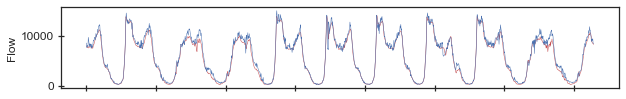

14049 WB P0
process ann data
process ann data
train mae 38.475708
test mae 43.316315
base train mae 591.91565
base test mae 595.2477
test mre 0.1463888
test rmse 59.96478865889757
base model train error [3378656.2]
base model test error [867276.]
our model train error [219618.9]
our model test error [63111.92]
Model R square (train):  0.9791964583086372
Model R square (test):  0.9737888640908641
Base R square (train):  -1.9916012867915964
Base R square (test):  -2.034682445808892


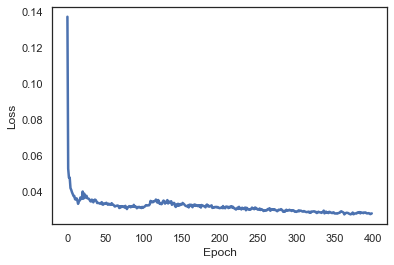

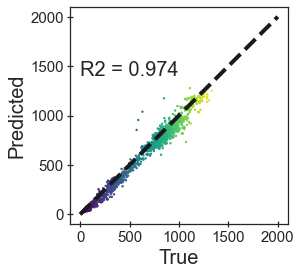

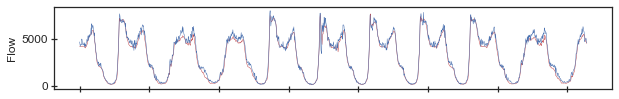

14037 WB P0
process ann data
process ann data
train mae 64.49299
test mae 67.56599
base train mae 978.65906
base test mae 973.35675
test mre 0.1450819
test rmse 91.62978543096672
base model train error [5586185.5]
base model test error [1418181.1]
our model train error [368126.6]
our model test error [98443.66]
Model R square (train):  0.9799739210448237
Model R square (test):  0.9773477197431254
Base R square (train):  -1.9909180339168513
Base R square (test):  -2.0241338357228327


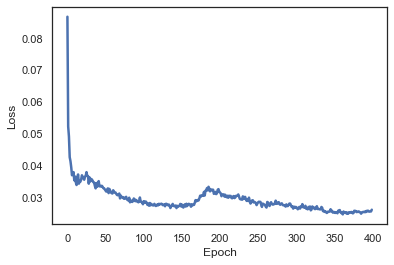

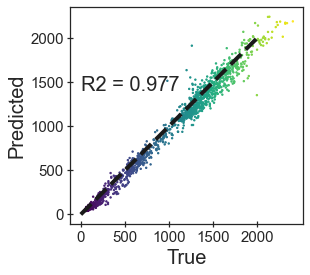

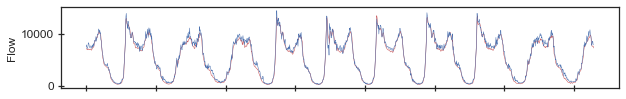

sums of MAE test /counter 53.41027750287737


In [30]:
final = pd.DataFrame()
MAE_RNN, MRE_RNN, RMSE_RNN = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    if len(tmp) == 0:
        print('error',siteId)
        continue

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    rnn_out = SimpleRNN(64,return_sequences=True, activation = 'linear',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([rnn_out, aux_input]) #concatenate auxiliary features with rnn output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) #plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_RNN[siteId] = res['test mae']
    MRE_RNN[siteId] = res['test mre']
    RMSE_RNN[siteId] = res['test rmse']

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "RNN\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_rnn.csv',index=False)

sums, counter = 0, 0
for key in MAE_RNN:
    sums += MAE_RNN[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

# return MAE_RNN
    

# LSTM

14025 WB P0
process ann data
process ann data
MAE 56.188282
MRE 0.12869741
RMSE 80.63767766121337


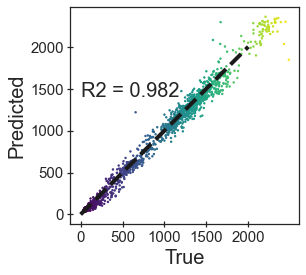

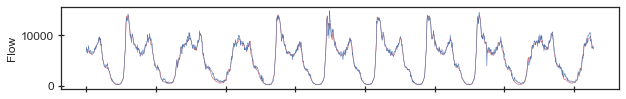

14005 WB P0
process ann data
process ann data
MAE 30.326096
MRE 0.09300637
RMSE 42.799577486323535


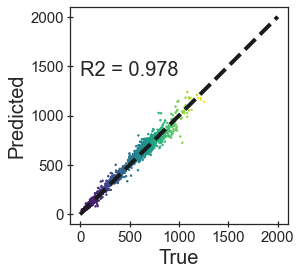

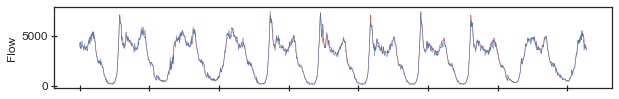

14011 WB P0
process ann data
process ann data
MAE 56.455097
MRE 0.12485156
RMSE 77.51428799743954


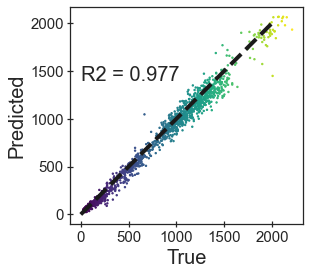

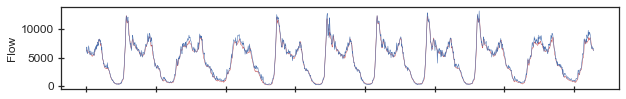

14063 WB P0
process ann data
process ann data
MAE 21.901087
MRE 0.17272663
RMSE 32.140661081044406


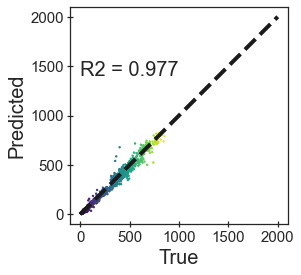

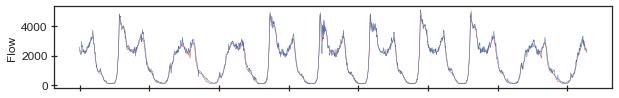

14055 WB P0
process ann data
process ann data
MAE 71.72899
MRE 0.14080381
RMSE 100.02748157537758


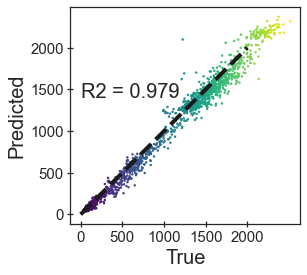

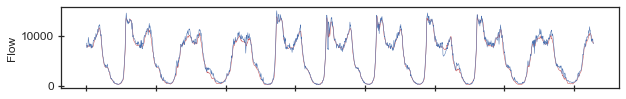

14049 WB P0
process ann data
process ann data
MAE 38.09252
MRE 0.14080217
RMSE 54.3757789994486


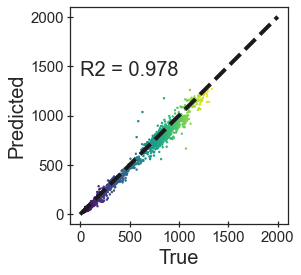

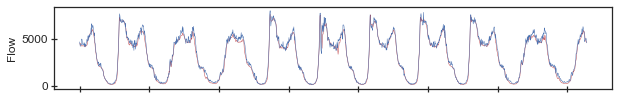

14037 WB P0
process ann data
process ann data
MAE 64.52232
MRE 0.11443175
RMSE 92.16940500377552


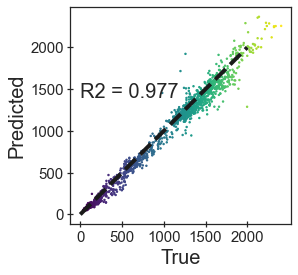

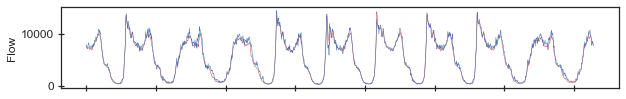

sums of MAE test /counter 48.45919936043875


In [31]:
final = pd.DataFrame()
MAE_LSTM, MRE_LSTM, RMSE_LSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_LSTM[siteId] = res['test mae']
    MRE_LSTM[siteId] = res['test mre']
    RMSE_LSTM[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "LSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_lstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_LSTM:
    sums += MAE_LSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# GRU

14025 WB P0
process ann data
process ann data
MAE 60.95394
MRE 0.15147899
RMSE 85.52452761762996


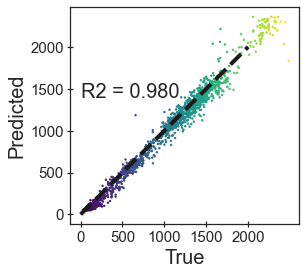

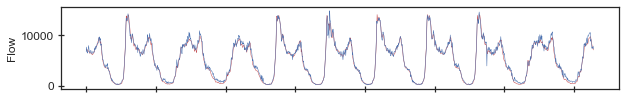

14005 WB P0
process ann data
process ann data
MAE 34.599022
MRE 0.13056585
RMSE 47.3303869342281


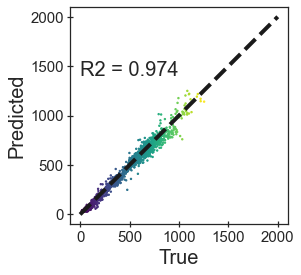

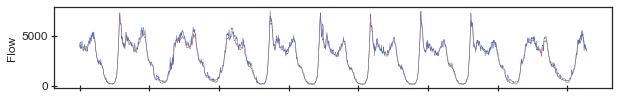

14011 WB P0
process ann data
process ann data
MAE 53.802322
MRE 0.09753998
RMSE 76.18211309401144


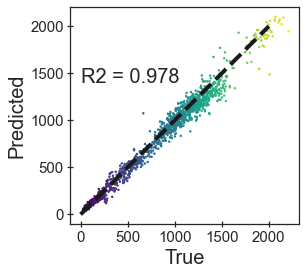

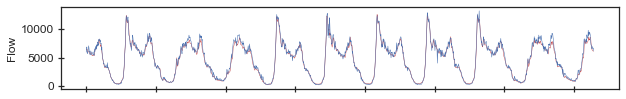

14063 WB P0
process ann data
process ann data
MAE 21.219442
MRE 0.14315474
RMSE 31.648346858670497


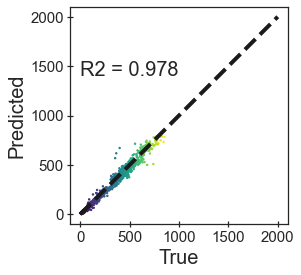

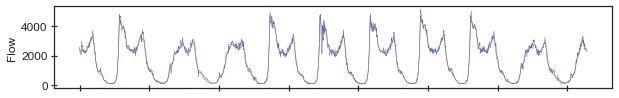

14055 WB P0
process ann data
process ann data
MAE 78.672455
MRE 0.21117412
RMSE 106.9121143524554


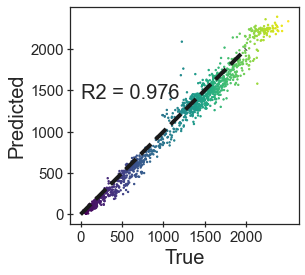

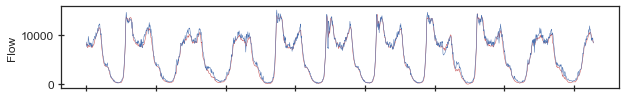

14049 WB P0
process ann data
process ann data
MAE 36.228436
MRE 0.117391005
RMSE 51.32890743315359


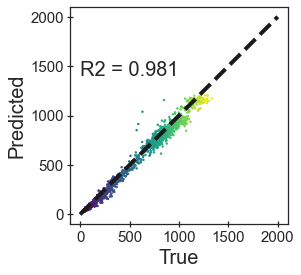

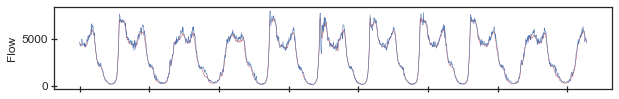

14037 WB P0
process ann data
process ann data
MAE 63.723694
MRE 0.13942654
RMSE 88.63032479155342


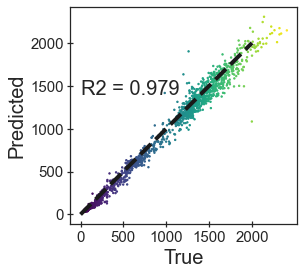

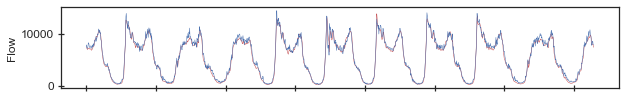

sums of MAE test /counter 49.88561603001186


In [32]:
final = pd.DataFrame()
MAE_GRU, MRE_GRU, RMSE_GRU = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    gru_out = GRU(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([gru_out, aux_input]) #concatenate auxiliary features with gru output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_GRU[siteId] = res['test mae']
    MRE_GRU[siteId] = res['test mre']
    RMSE_GRU[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "GRU\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_gru.csv',index=False)

sums, counter = 0, 0
for key in MAE_GRU:
    sums += MAE_GRU[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# Bidirectional LSTM

14025 WB P0
process ann data
process ann data
train mae 50.55065
test mae 54.21313
base train mae 960.2717
base test mae 957.29205
test mre 0.12729332
test rmse 77.96632636513664
base model train error [5481230.]
base model test error [1394774.6]
our model train error [288544.]
our model test error [78988.62]
Model R square (train):  0.986911318289042
Model R square (test):  0.9834246779887784
Base R square (train):  -1.8554813539865083
Base R square (test):  -1.9010113697500208


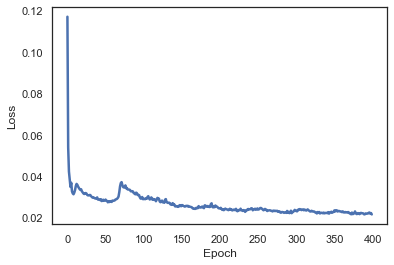

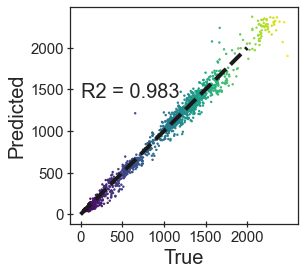

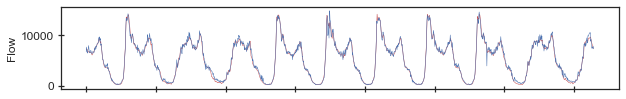

14005 WB P0
process ann data
process ann data
train mae 37.12626
test mae 40.918846
base train mae 444.871
base test mae 464.02466
test mre 0.139236
test rmse 55.085883762028814
base model train error [2539324.]
base model test error [676083.9]
our model train error [211916.8]
our model test error [59618.79]
Model R square (train):  0.9687735636186552
Model R square (test):  0.9642471983013241
Base R square (train):  -1.939917243276974
Base R square (test):  -2.029742498002954


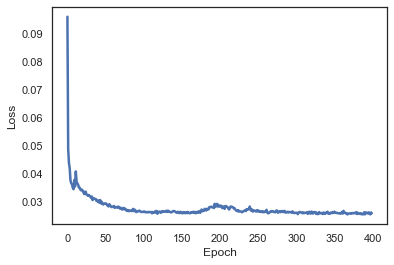

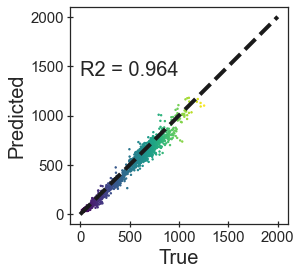

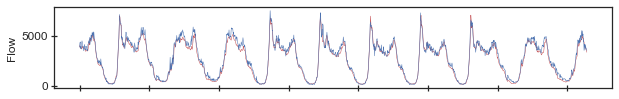

14011 WB P0
process ann data
process ann data
train mae 49.651066
test mae 55.653458
base train mae 802.57025
base test mae 801.7417
test mre 0.136905
test rmse 75.56332389439171
base model train error [4581071.]
base model test error [1168137.5]
our model train error [283408.22]
our model test error [81087.13]
Model R square (train):  0.982671146129923
Model R square (test):  0.9782158606432537
Base R square (train):  -1.848967053685731
Base R square (test):  -1.8901742507247379


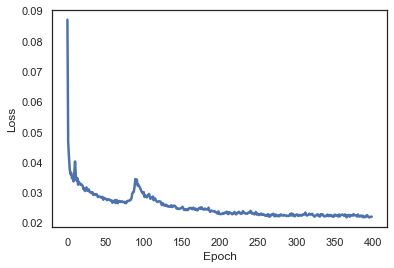

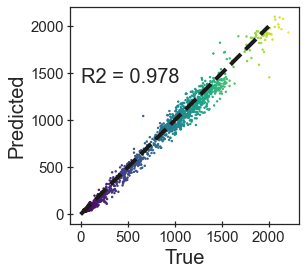

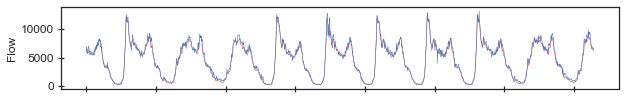

14063 WB P0
process ann data
process ann data
train mae 20.82885
test mae 22.08847
base train mae 339.58508
base test mae 333.9512
test mre 0.15708344
test rmse 32.813186376749705
base model train error [1938353.]
base model test error [486567.]
our model train error [118891.21]
our model test error [32182.92]
Model R square (train):  0.9804675484319194
Model R square (test):  0.9759731872224616
Base R square (train):  -1.8535261134745817
Base R square (test):  -1.9134284655610925


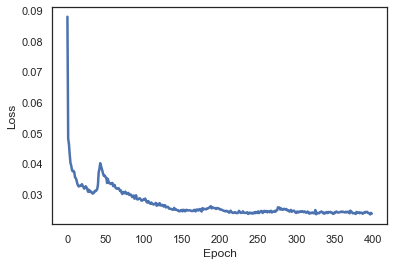

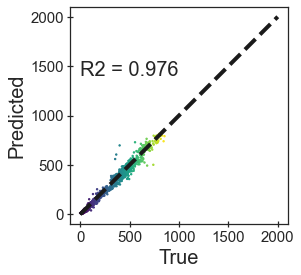

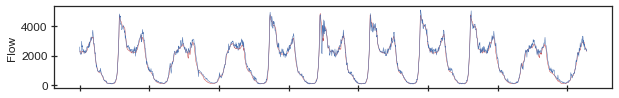

14055 WB P0
process ann data
process ann data
train mae 70.974655
test mae 75.88394
base train mae 1115.3179
base test mae 1107.8965
test mre 0.28133583
test rmse 105.15139754777394
base model train error [6366235.5]
base model test error [1614205.2]
our model train error [405123.12]
our model test error [110562.88]
Model R square (train):  0.9818155582351215
Model R square (test):  0.9768672396801663
Base R square (train):  -1.9585145458578728
Base R square (test):  -2.0118294712927582


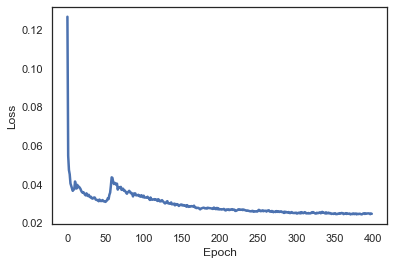

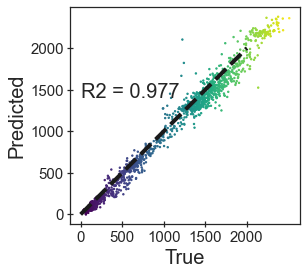

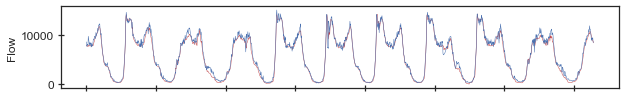

14049 WB P0
process ann data
process ann data
train mae 34.546604
test mae 36.62767
base train mae 591.91565
base test mae 595.2477
test mre 0.14393142
test rmse 51.231506285957714
base model train error [3378656.2]
base model test error [867276.]
our model train error [197191.8]
our model test error [53366.523]
Model R square (train):  0.98329011785208
Model R square (test):  0.9808676846709954
Base R square (train):  -1.9916012867915964
Base R square (test):  -2.034682445808892


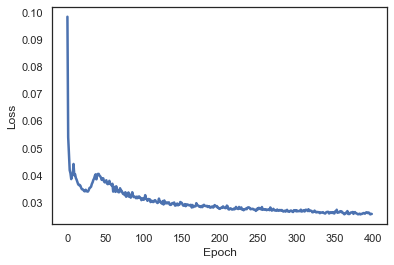

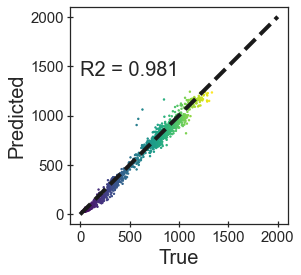

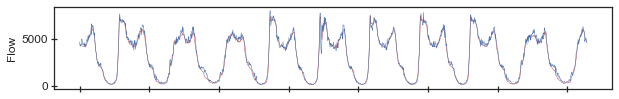

14037 WB P0
process ann data
process ann data
train mae 64.308716
test mae 67.419075
base train mae 978.65906
base test mae 973.35675
test mre 0.14660877
test rmse 92.35609583292269
base model train error [5586185.5]
base model test error [1418181.1]
our model train error [367073.78]
our model test error [98229.62]
Model R square (train):  0.9801425088914233
Model R square (test):  0.9769871859977839
Base R square (train):  -1.9909180339168513
Base R square (test):  -2.0241338357228327


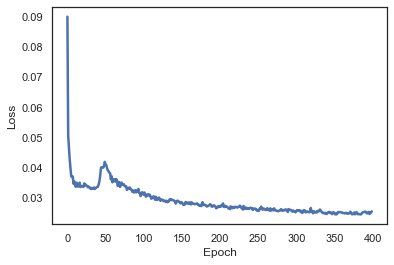

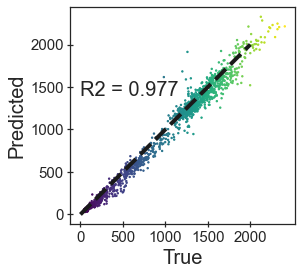

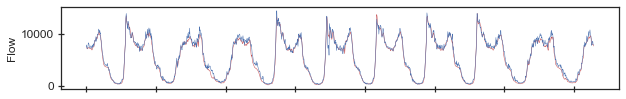

sums of MAE test /counter 50.400656018938335


In [33]:
final = pd.DataFrame()
MAE_BiLSTM, MRE_BiLSTM, RMSE_BiLSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = Bidirectional(LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001))) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])      


    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                   {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)


    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_BiLSTM[siteId] = res['test mae']
    MRE_BiLSTM[siteId] = res['test mre']
    RMSE_BiLSTM[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "BiLSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_bilstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_BiLSTM:
    sums += MAE_BiLSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)


# Regression Tree

14025 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 69.82328072972321
MRE 0.11327242446969035
RMSE 108.69031281742977


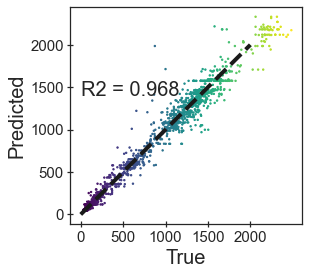

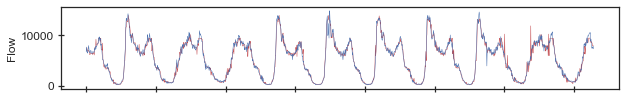

14005 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 39.78978067099715
MRE 0.11557962734350577
RMSE 56.52899110867033


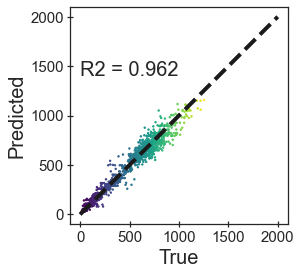

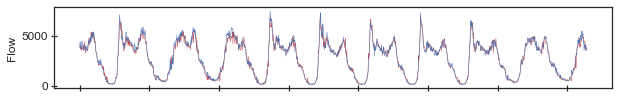

14011 WB P0
Best paramaters:  {'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 8} 

MAE 67.51841556655506
MRE 0.11283357593840977
RMSE 104.04793868673035


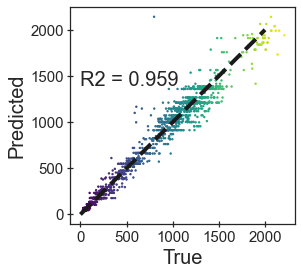

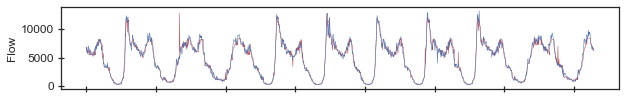

14063 WB P0
Best paramaters:  {'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 10} 

MAE 26.215300921660244
MRE 0.1324620477458222
RMSE 42.61585094624849


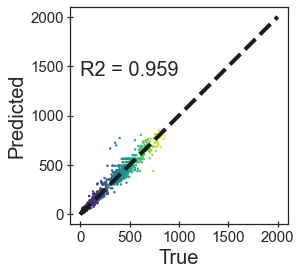

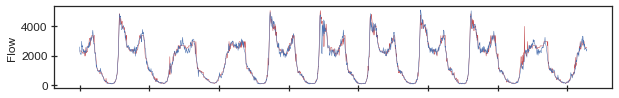

14055 WB P0
Best paramaters:  {'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 8} 

MAE 79.13456081819919
MRE 0.10951406572948569
RMSE 122.90899975943341


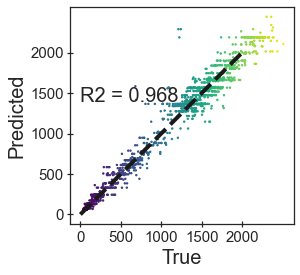

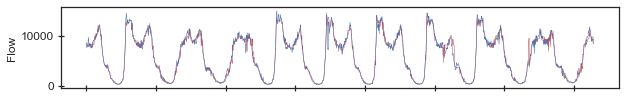

14049 WB P0
Best paramaters:  {'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 8} 

MAE 40.22645179636414
MRE 0.10236064112896698
RMSE 64.04096915845035


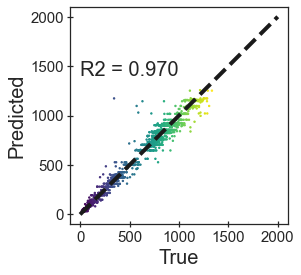

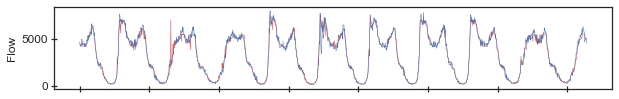

14037 WB P0
Best paramaters:  {'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 8} 

MAE 73.08028960502374
MRE 0.11382515587487446
RMSE 107.15046454627057


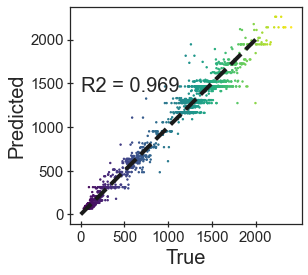

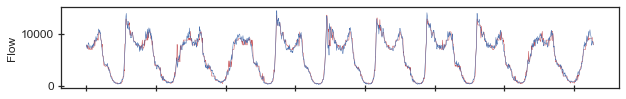

sums of MAE test /counter 56.54115430121753


In [39]:
final = pd.DataFrame()
MAE_RT, MRE_RT, RMSE_RT = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # we use 'vol - 0' as the prediction target
    # vol-x means how much hour before vol-0
    y_train = train['volume0'] #not normalised travel times 
    x_train = train[columns]
    y_test = test['volume0'] #not normalised travel times 
    x_test = test[columns]

    
    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    dt_model = DecisionTreeRegressor() 
    tuning_parameters = {
        #the number of features to consider when looking for best split.
        'max_features': [1,2,3,4,5,6],
        #minimum number of samples required to be at the leaf node.
        'min_samples_leaf': [1, 5, 10, 20],
        'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    }
    dt_search = RandomizedSearchCV(dt_model, tuning_parameters, cv = 10, n_iter = 20,
                                  return_train_score = False, n_jobs = 4, 
                                  random_state = 20)

    #fitting the random forest model. Takes around 2 minutes to run.  
    dt_search.fit(x_train_win, y_train_win) 
    dt = dt_search.best_estimator_ 
    print("Best paramaters: ", dt_search.best_params_, '\n')

    ### Save regression tree model.
    pkl_folder = os.getcwd() + "\\Models\\RT\\" 
    pkl_filename = pkl_folder + "RT_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    if not os.path.exists(pkl_folder):                                       # create folder to store BFS results
        os.makedirs(pkl_folder)

    with open(pkl_filename, 'wb') as file:
        pickle.dump(dt_search, file)
    
#     pkl_folder = os.getcwd() + "\\Models\\RT\\" 
#     pkl_filename = pkl_folder + "RT_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
#     dt_search= pickle.load(open(pkl_filename,'rb'))

    
    # forecasting results
    y_pred_train = dt_search.predict(x_train_win)
    y_pred_test = dt_search.predict(x_test_win)

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    MAE_RT[siteId] = res['MAE test']
    MRE_RT[siteId] = res['MRE test']
    RMSE_RT[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])
    
    show_time_scatter_plot(y_test_win,y_pred_test, title = "RT\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_rt.csv',index=False)

sums, counter = 0, 0
for key in MAE_RT:
    sums += MAE_RT[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

#return MAE_RT

14025 WB P0


One or more of the test scores are non-finite: [0.95137697        nan        nan 0.9628005  0.9513923  0.95274866
 0.95166883 0.95363732 0.95143267 0.95196936 0.95819026 0.95958756
 0.96975775 0.95142807 0.95142369 0.95320411 0.95242432 0.95760969
 0.95069967        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 83.91237971663986
MRE 0.17264521648022657
RMSE 106.0869902016834


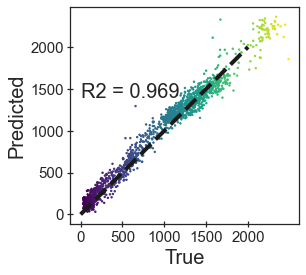

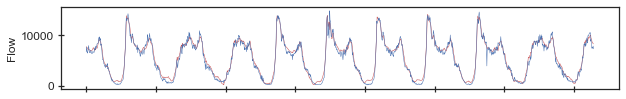

14005 WB P0


One or more of the test scores are non-finite: [0.94053428        nan        nan 0.95933076 0.93901794 0.94315521
 0.94088995 0.94417798 0.93889092 0.94122725 0.95009601 0.95592084
 0.96139127 0.93853123 0.93812702 0.943544   0.94692135 0.94983822
 0.9398236         nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 45.36523725840834
MRE 0.16247087408449035
RMSE 56.2781506427444


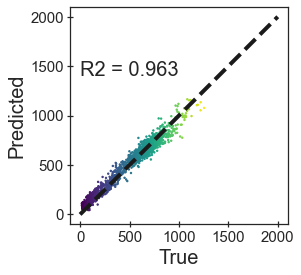

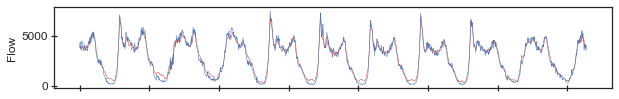

14011 WB P0


One or more of the test scores are non-finite: [0.94481183        nan        nan 0.96466375 0.94442047 0.94798184
 0.94502809 0.94810936 0.94437345 0.94511901 0.95658737 0.95484853
 0.9672496  0.94430896 0.94416061 0.94815645 0.95152953 0.95615706
 0.94391153        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 72.2295609000528
MRE 0.42366757206292843
RMSE 91.46415213216586


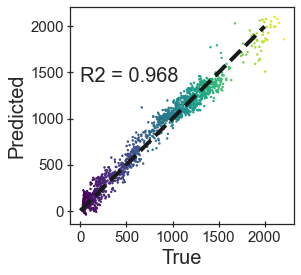

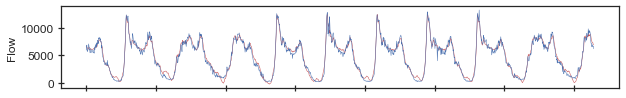

14063 WB P0


One or more of the test scores are non-finite: [0.95108768        nan        nan 0.96214426 0.95033033 0.9527565
 0.95154156 0.95369131 0.95012102 0.95175805 0.95511587 0.95340369
 0.96637978 0.94969112 0.94925764 0.95311477 0.95099483 0.95465678
 0.94950052        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 29.561781030579056
MRE 0.37379036397881915
RMSE 38.80148481728507


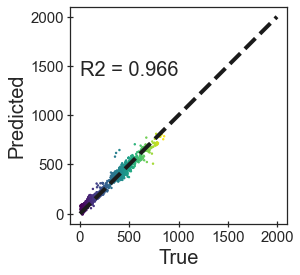

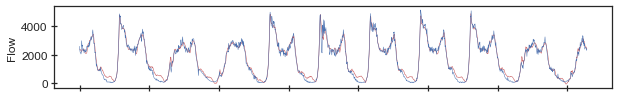

14055 WB P0


One or more of the test scores are non-finite: [0.95813936        nan        nan 0.96805664 0.95694739 0.96027238
 0.95835712 0.9612714  0.95680157 0.95847279 0.96498299 0.96461422
 0.97063421 0.95665227 0.95644465 0.96066582 0.96281874 0.96480286
 0.95794455        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 96.6743479866267
MRE 0.18504629377530055
RMSE 121.29423634352753


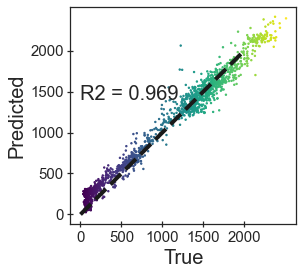

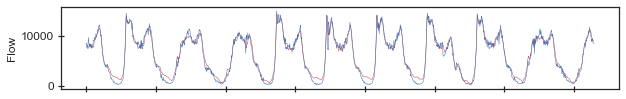

14049 WB P0


One or more of the test scores are non-finite: [0.95638905        nan        nan 0.96471268 0.95596387 0.95790028
 0.95660107 0.95921008 0.95599444 0.95660717 0.96125577 0.96190244
 0.96681953 0.95596508 0.95590495 0.95874481 0.95921641 0.96080962
 0.95567987        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 58.82019760782455
MRE 0.19910043206640948
RMSE 71.31455322903328


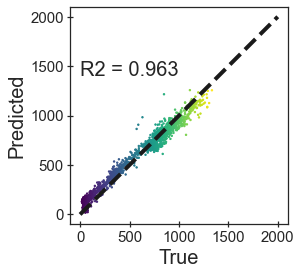

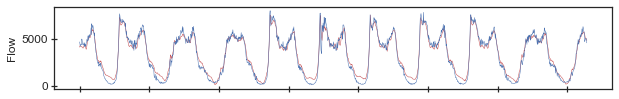

14037 WB P0


One or more of the test scores are non-finite: [0.95142629        nan        nan 0.96380181 0.9503475  0.95335899
 0.95165604 0.95428963 0.95020116 0.95164311 0.95699363 0.958047
 0.96655815 0.95028073 0.95018452 0.95386584 0.95528236 0.95642496
 0.95116827        nan]


Best paramaters:  {'kernel': 'rbf', 'gamma': 0.2, 'C': 1} 

MAE 88.462749649044
MRE 0.1697224958394988
RMSE 110.62740025261729


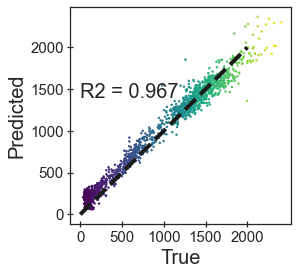

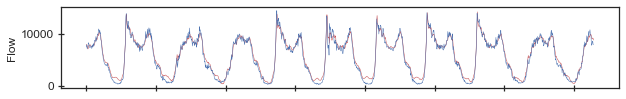

sums of MAE test /counter 67.86089344988218


In [41]:
final = pd.DataFrame()
MAE_SVR, MRE_SVR, RMSE_SVR = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)
    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    ### make sure you feed normalised data only. 
    svr_model = SVR()
    tuning_parameters = {
        'kernel': ['rbf'],
        'gamma': [0.2, 0.4, 0.6, 0.8, 1],
        'C': [0, 0.2, 0.4, 0.6, 0.8, 1]

    }
    svr_search = RandomizedSearchCV(svr_model, tuning_parameters, cv = 10, n_iter = 20,
                                  return_train_score = False, n_jobs = 4, 
                                  random_state = 20)

    svr_search.fit(x_train_win, y_train_win)
    svr = svr_search.best_estimator_ 
    print("Best paramaters: ", svr_search.best_params_, '\n')

    ### Save the models.
    pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
    pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    if not os.path.exists(pkl_folder):                                       # create folder to store BFS results
        os.makedirs(pkl_folder)

    pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
    pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(svr, file)

#     pkl_folder = os.getcwd() + "\\Models\\SVR\\" 
#     pkl_filename = pkl_folder + "SVR_model_lag_" + str(lag) + "_" + str(siteId) + ".pkl"
#     svr_search = pickle.load(open(pkl_filename,'rb'))

    # forecasting results
    y_pred_train_origin = svr_search.predict(x_train_win)
    y_pred_test_origin = svr_search.predict(x_test_win)

    # de-normalize the results
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    # all results:
    # y_train_win : normalized   y_pred_train_origin : normalized   --- they need be compared at same level
    # y_test_win : not nrom   y_pred_test : not norm                --- they need be compared at same level
    # y_train_win : normalized    y_train_win_base : normalized     --- they need be compared at same level
    # y_test_win : not nrom    y_test_win_base : normalized         --- they cannot be compared at same level, because y_test_win_base comes from normalized x
    # thus
    y_test_win_base_from_x = test[features_name][:-lag]    #  y_test_win : not nrom    y_test_win_base_from_x : not nrom        --- they cannot be compared at same level

    MAE_SVR[siteId] = res['MAE test']
    MRE_SVR[siteId] = res['MRE test']
    RMSE_SVR[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])

    show_time_scatter_plot(y_test_win,y_pred_test,title = "SVR\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_svr.csv',index=False)

sums, counter = 0, 0
for key in MAE_SVR:
    sums += MAE_SVR[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



## Final statistics

In [34]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_RNN[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_RNN[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_RNN[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 53.41027750287737
sums of MRE test /counter 0.1433302430169923
sums of RMSE test /counter 74.515963644839


In [35]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_LSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_LSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_LSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 48.45919936043875
sums of MRE test /counter 0.13075995870998927
sums of RMSE test /counter 68.52355282923179


In [36]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_GRU[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_GRU[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_GRU[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 49.88561603001186
sums of MRE test /counter 0.14153303312403814
sums of RMSE test /counter 69.6509601545289


In [37]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_BiLSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_BiLSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_BiLSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 50.400656018938335
sums of MRE test /counter 0.16177053962435042
sums of RMSE test /counter 70.02396000928017


In [42]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_RT[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_RT[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_RT[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 56.54115430121753
sums of MRE test /counter 0.11426393403296504
sums of RMSE test /counter 86.56907528903332


In [43]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_SVR[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_SVR[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_SVR[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 67.86089344988218
sums of MRE test /counter 0.2409204640410962
sums of RMSE test /counter 85.12385251700812


## No Model

In [28]:
final = pd.DataFrame()
MAE_NM, MRE_NM, RMSE_NM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 
    
    # we use 'vol - 0' as the prediction target
    # vol-x means how much hour before vol-0
    y_train = train['volume0'] #not normalised travel times 
    x_train = train[columns]
    y_test = test['volume0'] #not normalised travel times 
    x_test = test[columns]

    
    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    
    # forecasting results
    y_pred_train = x_train[columns[0]].values.tolist()[:-lag]
    y_pred_test = x_test[columns[0]].values.tolist()[:-lag]
    #print(y_pred_train)

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    MAE_NM[siteId] = res['MAE test']
    MRE_NM[siteId] = res['MRE test']
    RMSE_NM[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])
    
    #show_time_scatter_plot(y_test_win,y_pred_test, title = "NM\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_nm.csv',index=False)

sums, counter = 0, 0
for key in MAE_NM:
    sums += MAE_NM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

14063 WB P0
MAE 227.5577698087432
MRE 5.441103122006991
RMSE 290.7717879818467
14005 WB P0
MAE 316.2717713212334
MRE 3.1029241847115343
RMSE 394.6874040812967
14049 WB P0
MAE 405.478981264637
MRE 3.727515603534091
RMSE 504.3097985184252
14055 WB P0
MAE 753.6767710772834
MRE 3.91717834889051
RMSE 943.0534783535269
14037 WB P0
MAE 668.1787431693989
MRE 3.1513536920474694
RMSE 828.6401734181379
14011 WB P0
MAE 569.0439890710381
MRE 3.6562906865644553
RMSE 714.504344674919
14025 WB P0
MAE 669.9843091334894
MRE 4.175345570672802
RMSE 845.4395312324768
sums of MAE test /counter 515.7417621208318


In [29]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_NM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_NM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_NM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 515.7417621208318
sums of MRE test /counter 3.881673029775407
sums of RMSE test /counter 645.9152168943757


# MLP

In [55]:
final = pd.DataFrame()
MAE_MLP, MRE_MLP, RMSE_MLP = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    ################
    # Section 2 : model
    ################

    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    history = model.fit(train_x, train_y, epochs=400, batch_size=32, shuffle = False, verbose=0)
    
    
    filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    ################
    # Section 3 : evaluation
    ################
    ## visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict(train_x)
    y_pred_test_origin = model.predict( test_x)

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])

    MAE_MLP[siteId] = res['test mae']
    MRE_MLP[siteId] = res['test mre']
    RMSE_MLP[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "MLP\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_mlp.csv',index=False)

sums, counter = 0, 0
for key in MAE_MLP:
    sums += MAE_MLP[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

